In [41]:
# Import relevant packages
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import re
import pyLDAvis
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
from nltk import PorterStemmer as stemmer
nltk.download('wordnet')
import pandas as pd
import numpy as np
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint
#import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from gensim.corpora import Dictionary
# feed the LDA model into the pyLDAvis instance
#lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)
from gensim.models.ldamulticore import LdaMulticore
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import seaborn as sns

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# Read in dataset
twitter_df = pd.read_csv("processed_dataset.csv")
# Read in any other subsections of the dataset if relevant here
# Smell
# twitter_df = twitter_df.loc[twitter_df['smell'] == 'Yes']
# Sound
# twitter_df = twitter_df.loc[twitter_df['sound'] == 'Yes']
# Pre-COVID
# twitter_df = twitter_df.loc[twitter_df['created_at'] <= "2020-03-20"]
# Post-COVID
# twitter_df = twitter_df.loc[twitter_df['created_at'] >= "2020-03-20"]
# Just positive tweets
# twitter_df = twitter_df.loc[twitter_df['Sentiment'] == 'Positive']
# Just negative tweets
# twitter_df = twitter_df.loc[twitter_df['Sentiment'] == 'Negative']

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# We want to get rid of any tweet with less than three words due to sparsity issues when it comes to actual topic analysis
twitter_df['word_count'] = [len(x.split()) for x in twitter_df['text'].tolist()]
twitter_df = twitter_df[twitter_df['word_count'] > 3]

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Due to difficulties in the topic analysis otherwise - we drop the word amp by first removing the tokenisation structure
# removing "amp" and then re-tokenising
# We then re-tokenise the text
twitter_df['text'] = twitter_df['text'].str.replace("'", "")
twitter_df['text'] = twitter_df['text'].str.replace(",", "")
twitter_df['text'] = twitter_df['text'].str.replace("[", "")
twitter_df['text'] = twitter_df['text'].str.replace("]", "")
twitter_df['text'] = twitter_df['text'].str.replace("amp", "")
new_stopwords = ["amp"]
twitter_df['text'] = twitter_df['text'].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in new_stopwords))

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Here we take the text, tokenise and convert to list
twitter_df['tokenised_text'] = twitter_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
texts = twitter_df['tokenised_text'].tolist()
# Tokenise the list of words
def sent_to_words(tweets):
    for tweet in tweets:
        yield(gensim.utils.simple_preprocess(str(tweet), deacc=True))  # deacc removes punctuation
# Apply the function
data_words = list(sent_to_words(texts))

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# We vectorise the text separately
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(twitter_df['text'])
# Build a dictionary where for each tweet, each word has its own id.
tweets_dictionary = Dictionary(data_words)
# Build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in texts]

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1
1
1
1
1
1
1
1
1
1
1
1
1


Text(0, 0.5, 'Coherence Score')

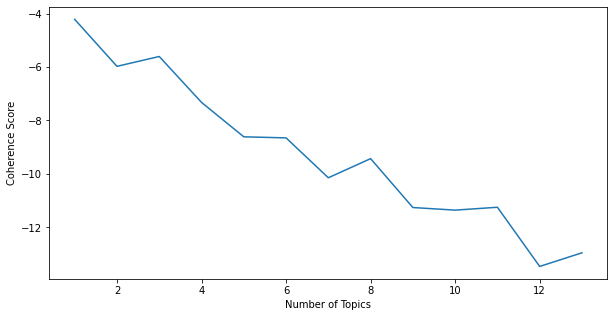

In [35]:
# Next we plot and compute the topic coherence for each topics from 1-14
# Please note that this takes some time but is necessary to understand coherence
# Compute the coherence
tweets_coherence_score = []
for number_of_topics in range(1, 14):
    lda = LdaModel(tweets_corpus, num_topics = number_of_topics, id2word = tweets_dictionary, passes=10)
    print(1)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh_score = cohm.get_coherence()
    tweets_coherence_score.append(coh_score)
# Visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,14), tweets_coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

In [36]:
# Now we run our actual defined lda model
# topics defined
topics = 5
tweets_lda = LdaModel(tweets_corpus, num_topics = topics, id2word = tweets_dictionary, passes=10)

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
#Creating Topic Distance Visualization using the pyLDAVis package
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(tweets_lda, tweets_corpus, tweets_dictionary)
lda_viz

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.072721 -0.030244       1        1  21.193065
1     -0.029203  0.054218       2        1  21.167391
3      0.204933  0.022996       3        1  19.984419
2     -0.026682 -0.179550       4        1  19.662432
4     -0.076326  0.132581       5        1  17.992693, topic_info=           Term        Freq       Total Category  logprob  loglift
149      street  240.000000  240.000000  Default  30.0000  30.0000
144      oxford  130.000000  130.000000  Default  29.0000  29.0000
61         feel   69.000000   69.000000  Default  28.0000  28.0000
852      missed  132.000000  132.000000  Default  27.0000  27.0000
2066      hotel   66.000000   66.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
775        live   23.807939   90.962139   Topic5  -5.8836   0.3748
5515  cocktails   17.216642   31.378032   Topic5  -6.2077   1.1150
502        year   19.850605   68.787019   Topic5  -6.0653   0.4724
731        like   19.537941   82.709305   Topic5  -6.0812   0.2722
495        come   17.241239   56.111753   Topic5  -6.2063   0.5352

[346 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3785      3  0.946633  activists
6482      2  0.982506         ah
772       3  0.980631       aint
3019      3  0.939310      album
614       3  0.943264        ale
...     ...       ...        ...
68        3  0.767332  yesterday
444       4  0.910299      youll
604       1  0.210331      youre
604       2  0.709868      youre
604       5  0.052583      youre

[544 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5])

In [38]:
# Build the model of topics using topic frequency
topics = [tweets_lda[tweets_corpus[i]] for i in range (len(twitter_df))]

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
#Convert topics to dataframe
def tweets_document_to_dataframe(tweets_doc, num_topics):
    # Initialise dataframe with number of columns equal to number of columns
    res = pd.DataFrame(columns=range(num_topics))
    for tweet_value in tweets_doc:
        res.loc[0, tweet_value[0]] = tweet_value[1]
    return res
tweet_topic = pd.concat([tweets_document_to_dataframe(tweets_document, num_topics=6) for tweets_document in topics]).reset_index(drop=True).fillna(0)

C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\patri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


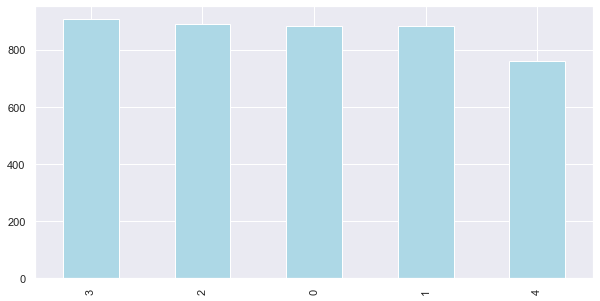

In [42]:
# Plot the distribution by topic
sns.set(rc={'figure.figsize':(10,5)})
tweet_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')
df = pd.DataFrame(tweet_topic.idxmax(axis=1).value_counts())
df = df.reset_index()

In [ ]:
# Final step is to replace topic number with the name of the topic that you have defined
# Unfortunately this has be done manually to restructure the graph
# Rename the topic numbers above in the graph by full name - example given below
df = df.replace([1, 0, 4, 5, 2, 3],["Photography - Topic 2", "Good times - Topic 1", "Shopping - Topic 5", "Food - Topic 6", "Street observations - Topic 3", "Positive emotions - Topic 4"])
df = df.reset_index()
df = df.rename(columns={"index":"Topic description", 0:"Tweet count"})
ax = df.plot.bar(x = 'Topic description', y = "Tweet count", rot = 45)